In [1]:
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from matplotlib import pyplot as plt

# 设置中文字体和负号正常显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据  
df = pd.read_csv('./Lingcang202001-202312.csv')
df = df[['year', 'month', 'day', 'average']]  # 筛选需要的列  

# 将年月日合并为一个日期列，方便筛选  
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# 训练集: 2020年1月1日-2022年11月30日  
train_start = datetime(2020, 1, 1)
train_end = datetime(2022, 11, 30)
df_train = df[(df['date'] >= train_start) & (df['date'] <= train_end)]

# 验证集: 2022年12月1日-2022年12月31日  
val_start = datetime(2022, 12, 1)
val_end = datetime(2022, 12, 31)
df_val = df[(df['date'] >= val_start) & (df['date'] <= val_end)]

# 测试集: 2023年1月1日-2023年12月31日  
test_start = datetime(2023, 1, 1)
test_end = datetime(2023, 12, 31)
df_test = df[(df['date'] >= test_start) & (df['date'] <= test_end)]

# 删除原始的日期列，如果不需要的话  
df_train = df_train.drop('date', axis=1)
df_val = df_val.drop('date', axis=1)
df_test = df_test.drop('date', axis=1)

Epoch 1/100
67/67 [==============================] - 1s 4ms/step - loss: 325.0382 - val_loss: 72.7081
Epoch 2/100
67/67 [==============================] - 0s 2ms/step - loss: 161.8060 - val_loss: 44.8499
Epoch 3/100
67/67 [==============================] - 0s 2ms/step - loss: 36.5986 - val_loss: 187.5555
Epoch 4/100
67/67 [==============================] - 0s 2ms/step - loss: 29.2769 - val_loss: 163.9878
Epoch 5/100
67/67 [==============================] - 0s 2ms/step - loss: 26.2815 - val_loss: 157.1801
Epoch 6/100
67/67 [==============================] - 0s 3ms/step - loss: 23.7092 - val_loss: 135.1887
Epoch 7/100
67/67 [==============================] - 0s 2ms/step - loss: 21.6320 - val_loss: 140.2951
Epoch 8/100
67/67 [==============================] - 0s 2ms/step - loss: 19.7353 - val_loss: 115.1233
Epoch 9/100
67/67 [==============================] - 0s 2ms/step - loss: 18.1252 - val_loss: 113.5407
Epoch 10/100
67/67 [==============================] - 0s 2ms/step - loss: 16.7610 

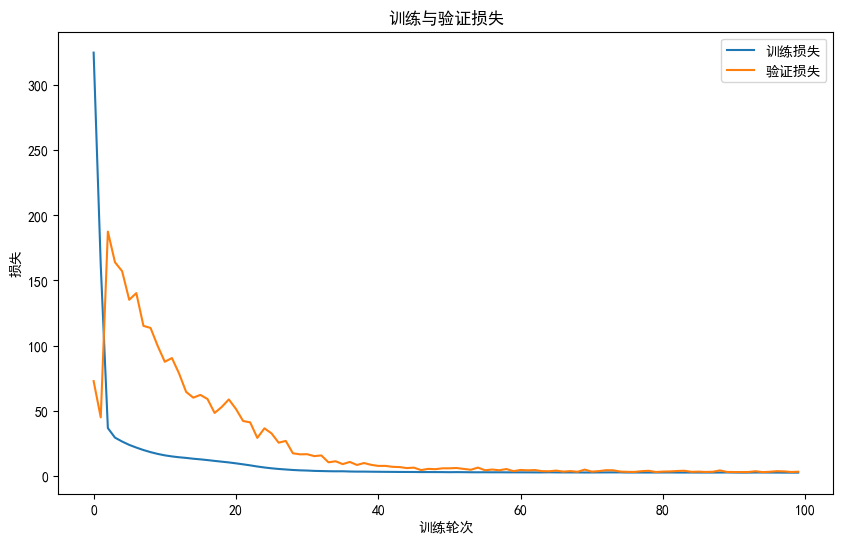

In [2]:
# 数据归一化 
scaler = MinMaxScaler()

# 拟合训练集数据 
X_train_scaled = scaler.fit_transform(df_train[['year', 'month', 'day']])
y_train = df_train['average'].values

# 使用相同的scaler转换验证集和测试集数据  
X_val_scaled = scaler.transform(df_val[['year', 'month', 'day']])
y_val = df_val['average'].values

X_test_scaled = scaler.transform(df_test[['year', 'month', 'day']])
y_test = df_test['average'].values

# 创建一个简单的MLP模型  
model = Sequential()  
model.add(Dense(64, activation='relu', input_shape=(3,)))  # 输入层输入维度为3
model.add(Dense(32, activation='relu'))  # 隐藏层
model.add(Dense(1))  # 用于预测平均温度的输出层 

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型并获取训练历史  
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, validation_data=(X_val_scaled, y_val))

# 绘制训练损失和验证损失  
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('训练与验证损失')
plt.xlabel('训练轮次')
plt.ylabel('损失')
plt.legend()
plt.show()

In [3]:
import joblib

# 评估模型  
val_loss = model.evaluate(X_val_scaled, y_val)
print(f"Validation Loss: {val_loss}")

# 计算验证集的平均绝对误差
predictions = model.predict(X_val_scaled)
mae = np.mean(np.abs(predictions.flatten() - y_val))
print(f" Mean Absolute Error (MAE): {mae:.2f}")

# 计算验证集的均方误差
mse = np.mean((predictions.flatten() - y_val) ** 2)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# 计算验证集的均方根误差
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# 计算验证集的平均绝对百分比误差
mape = np.mean(np.abs(predictions.flatten() - y_val) / y_val) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# 计算验证集的R2分数
r2 = 1 - (np.sum((y_val - predictions.flatten()) ** 2) / np.sum((y_val - np.mean(y_val)) ** 2))
print(f"R2 Score (R2): {r2:.2f}")

# 保存scaler  
scaler_path = './mlp_scaler.joblib'  # 定义scaler保存的文件路径  
joblib.dump(scaler, scaler_path)  # 使用joblib保存scaler对象  
print(f"Scaler saved to {scaler_path}")

# 保存整个模型  
model.save('MPL_temperature_prediction_model.h5')
print("模型已保存为 MPL_temperature_prediction_model.h5")

1/1 [==============================] - 0s 33ms/step - loss: 3.0795
Validation Loss: 3.079538106918335
1/1 [==============================] - 0s 97ms/step
 Mean Absolute Error (MAE): 1.23
Mean Squared Error (MSE): 3.08
Root Mean Squared Error (RMSE): 1.75
Mean Absolute Percentage Error (MAPE): 11.93%
R2 Score (R2): 0.27
Scaler saved to ./mlp_scaler.joblib
模型已保存为 MPL_temperature_prediction_model.h5


12/12 [==============================] - 0s 1ms/step


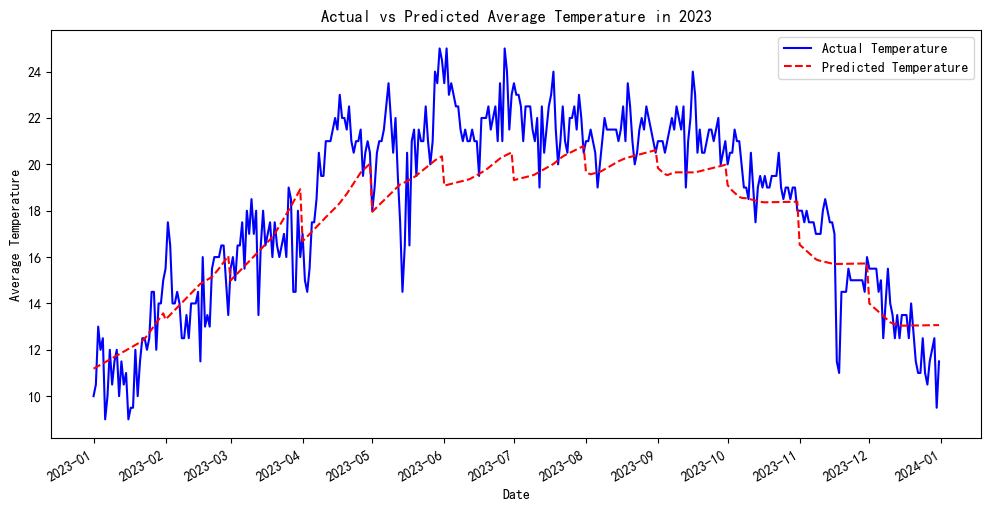

In [4]:
import matplotlib.dates as mdates
# 预测测试集数据 
predictions = model.predict(X_test_scaled)

# 将测试集的年月日信息转换为Matplotlib可以理解的日期格式  
dates = [mdates.date2num(datetime(year, month, day))
         for year, month, day in zip(df_test['year'], df_test['month'], df_test['day'])]

# 绘制预测值和真实值的对比图  
plt.figure(figsize=(12, 6))

# 绘制实际温度和预测温度的折线图  
plt.plot(mdates.num2date(dates), y_test, label='Actual Temperature', color='blue')
plt.plot(mdates.num2date(dates), predictions.flatten(), label='Predicted Temperature', color='red', linestyle='--')

# 设置图表标题和坐标轴标签  
plt.title('Actual vs Predicted Average Temperature in 2023')
plt.xlabel('Date')
plt.ylabel('Average Temperature')

# 设置x轴日期格式  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

# 添加图例  
plt.legend()

# 显示图表  
plt.show()

In [5]:
# 计算测试集的平均绝对误差
mae = np.mean(np.abs(predictions.flatten() - y_test))
print(f"Mean Absolute Error: {mae:.2f}")

# 计算测试集的均方误差
mse = np.mean((predictions.flatten() - y_test) ** 2)
print(f"Mean Squared Error: {mse:.2f}")

# 计算测试集的均方根误差
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

# 计算测试集的平均绝对百分比误差
mape = np.mean(np.abs(predictions.flatten() - y_test) / y_test) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

# 计算测试集的R2分数
r2 = 1 - (np.sum((y_test - predictions.flatten()) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
print(f"R2 Score: {r2:.2f}")

Mean Absolute Error: 1.61
Mean Squared Error: 3.85
Root Mean Squared Error: 1.96
Mean Absolute Percentage Error: 8.92%
R2 Score: 0.74


In [6]:
import pandas as pd

# Assuming you have a pre-trained model and a scaler fitted on a DataFrame with columns ['year', 'month', 'day']  

def predict_temperature(year, month, day):
    # 创建一个 DataFrame，其列名与用于适应缩放器的列名相同 
    input_data = pd.DataFrame({'year': [year], 'month': [month], 'day': [day]})

    # 对输入数据进行缩放
    input_data_scaled = scaler.transform(input_data)

    # 使用模型预测输入数据 
    prediction = model.predict(input_data_scaled)

    # 返回预测值  
    return prediction.flatten()[0]

  
temperature = predict_temperature(2023, 1, 1)
print(f"The predicted average temperature for January 1, 2024 is: {temperature:.2f}°C")
temperature2 = predict_temperature(2023, 5, 20)
print(f"The predicted average temperature for May 20, 2024 is: {temperature2:.2f}°C")

1/1 [==============================] - 0s 18ms/step
The predicted average temperature for January 1, 2024 is: 11.18°C
1/1 [==============================] - 0s 19ms/step
The predicted average temperature for May 20, 2024 is: 19.52°C


In [7]:
# 加载模型
from keras.models import load_model
loaded_model = load_model('MPL_temperature_prediction_model.h5')

# 进行预测
temperature = predict_temperature(2023, 10, 27)
print(f"The predicted average temperature for October 27, 2024 is: {temperature:.2f}°C")



1/1 [==============================] - 0s 17ms/step
The predicted average temperature for October 27, 2024 is: 18.38°C
